# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import random
!pip install tqdm ipywidgets


Defaulting to user installation because normal site-packages is not writeable


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Defining transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the dataset
mnist_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Defining the sizes of train, validation, and test sets
train_size = int(0.6 * len(mnist_dataset))  # 60% for training
val_size = int(0.2 * len(mnist_dataset))    # 20% for validation
test_size = len(mnist_dataset) - train_size - val_size  # Remaining for test (20%)

# Splitting the MNIST dataset 

train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# Create test set and define test dataloader
training_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
testing_loader = DataLoader(test_dataset, batch_size=128)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose the ToTensor() transform to convert MNIST images from PIL format to PyTorch tensors, ensuring compatibility with PyTorch models. Additionally, I used the Normalize((0.5,), (0.5,)) transform to scale pixel values from 0-255 to a range of -1 to 1. This normalization stabilizes and accelerates the training process. These preprocessing steps are standard for image data and are sufficient for the well-structured MNIST dataset, improving model performance.

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()


In [6]:
# Explore data
## YOUR CODE HERE ##

In [7]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

print("number of images: {}".format(images.shape))
print("number of labels: {}".format(labels.shape))

number of images: torch.Size([128, 1, 28, 28])
number of labels: torch.Size([128])


3


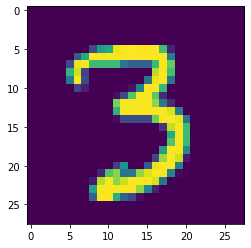

0


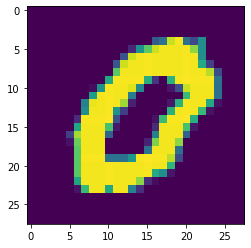

1


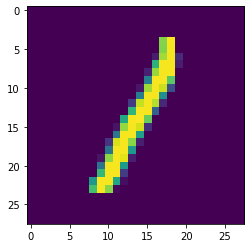

8


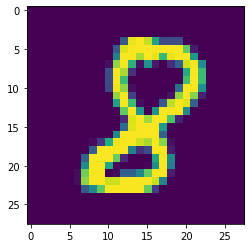

2


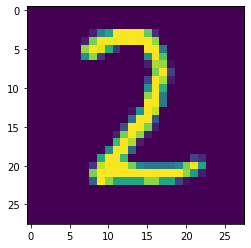

In [8]:
show5(training_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28 * 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        x = F.softmax(x, dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
net = Net()

# Choose an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99, weight_decay=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
# Number of epochs for training
num_epochs = 20

# Initializing lists to store the loss history for training and validation
train_loss_history = list()
val_loss_history = list()

# Starting the training process
for epoch in range(num_epochs):
    # Set the model to training mode to enable dropout and batch normalization
    net.train()
    
    # Resetting the loss and correct predictions counters for this epoch
    train_loss = 0.0
    train_correct = 0
    total_predictions = 0
    
    # Loop through the training data
    for i, data in enumerate(training_loader):
        inputs, labels = data
        
        # Move data to the GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward pass: compute the model output
        outputs = net(inputs)
    
        # Calculate the loss
        loss = criterion(outputs, labels)
    
        # Backward pass: compute the gradient of the loss w.r.t. model parameters
        loss.backward()
    
        # Update model parameters
        optimizer.step()
    
        # Get predictions from the output
        _, preds = torch.max(outputs.data, 1)
        
        # Update counters
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    # Print training accuracy and loss for this epoch
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(training_loader):.5f}")
    # Store average training loss for this epoch
    train_loss_history.append(train_loss/len(training_loader))
    
    # Begin validation phase
    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    # Set the model to evaluation mode to disable dropout and batch normalization
    net.eval()
    for inputs, labels in val_loader:
        # Move data to the GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass: compute the model output
        outputs = net(inputs)
        # Calculate the loss for the validation set
        loss = criterion(outputs, labels)
        
        # Get predictions from the output
        _, preds = torch.max(outputs.data, 1)
        
        # Update counters
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    
    # Print validation accuracy and loss for this epoch
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    # Store average validation loss for this epoch
    val_loss_history.append(val_loss/len(val_loader))


Epoch 1 training accuracy: 32.26% training loss: 2.13159
Epoch 1 validation accuracy: 67.67% validation loss: 1.78410
Epoch 2 training accuracy: 69.85% training loss: 1.76151
Epoch 2 validation accuracy: 70.43% validation loss: 1.75560
Epoch 3 training accuracy: 72.52% training loss: 1.73455
Epoch 3 validation accuracy: 72.30% validation loss: 1.73748
Epoch 4 training accuracy: 73.70% training loss: 1.72254
Epoch 4 validation accuracy: 71.66% validation loss: 1.74286
Epoch 5 training accuracy: 76.05% training loss: 1.70158
Epoch 5 validation accuracy: 82.24% validation loss: 1.64308
Epoch 6 training accuracy: 84.70% training loss: 1.61562
Epoch 6 validation accuracy: 87.55% validation loss: 1.58683
Epoch 7 training accuracy: 89.78% training loss: 1.56615
Epoch 7 validation accuracy: 87.42% validation loss: 1.58898
Epoch 8 training accuracy: 88.82% training loss: 1.57475
Epoch 8 validation accuracy: 88.93% validation loss: 1.57639
Epoch 9 training accuracy: 91.14% training loss: 1.55264

Plot the training loss (and validation loss/accuracy, if recorded).

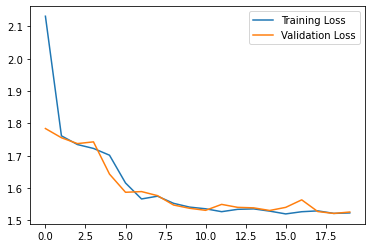

In [13]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in testing_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 94.30%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [15]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99, weight_decay= 0.001)

In [16]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
    
        loss = criterion(outputs, labels)
    
        loss.backward()
    
        optimizer.step()
    
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/len(training_loader.dataset) * 100:.2f}% training loss: {train_loss/len(training_loader):.5f}")
    train_loss_history.append(train_loss/len(training_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in testing_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/len(testing_loader.dataset) * 100:.2f}% validation loss: {val_loss/len(testing_loader):.5f}")
    val_loss_history.append(val_loss/len(testing_loader))

Epoch 1 training accuracy: 96.24% training loss: 1.50267
Epoch 1 validation accuracy: 96.08% validation loss: 1.50443
Epoch 2 training accuracy: 96.82% training loss: 1.49726
Epoch 2 validation accuracy: 96.31% validation loss: 1.50254
Epoch 3 training accuracy: 97.04% training loss: 1.49547
Epoch 3 validation accuracy: 96.20% validation loss: 1.50433
Epoch 4 training accuracy: 97.17% training loss: 1.49472
Epoch 4 validation accuracy: 96.38% validation loss: 1.50286
Epoch 5 training accuracy: 97.27% training loss: 1.49408
Epoch 5 validation accuracy: 96.48% validation loss: 1.50164
Epoch 6 training accuracy: 97.39% training loss: 1.49355
Epoch 6 validation accuracy: 96.43% validation loss: 1.50251
Epoch 7 training accuracy: 97.41% training loss: 1.49331
Epoch 7 validation accuracy: 96.53% validation loss: 1.50187
Epoch 8 training accuracy: 97.46% training loss: 1.49263
Epoch 8 validation accuracy: 96.44% validation loss: 1.50255
Epoch 9 training accuracy: 97.57% training loss: 1.49207

In [17]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in testing_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.83%


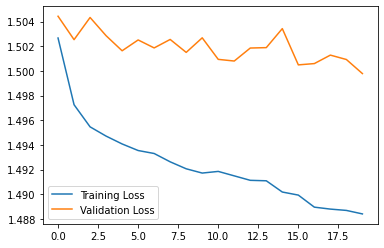

In [18]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Saving your model
Using `torch.save`, save your model for future loading.

In [19]:
## YOUR CODE HERE ##

In [20]:
torch.save(net.state_dict(), "saved_model.pth")

In [21]:

#Sanity checking was added at a later stage. To avoid retraining the model, we will directly load the previously trained checkpoint.

In [22]:
# Initialize the model class, assuming it is named Net
net = Net()

# Load the model from the saved file
model_path = "saved_model.pth"
checkpoint = torch.load(model_path)

# Verify if 'model_state_dict' exists in the checkpoint
if 'model_state_dict' in checkpoint:
    # Load the model's parameters from the state_dict
    net.load_state_dict(checkpoint['model_state_dict'])
    print("Model successfully loaded.")
else:
    # If 'model_state_dict' is not found, load the full state dictionary
    net.load_state_dict(checkpoint)
    print("Model successfully loaded (full state dictionary).")

# If the optimizer's state was also saved, reload it
if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# If additional information like training epochs or loss history was saved, restore it as well
# For example, restoring the number of epochs
if 'epoch' in checkpoint:
    epoch = checkpoint['epoch']

# Set the model to the correct device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()


Model successfully loaded (full state dictionary).


Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

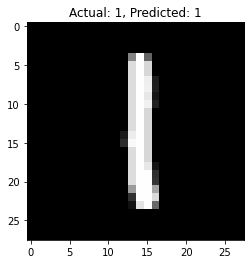

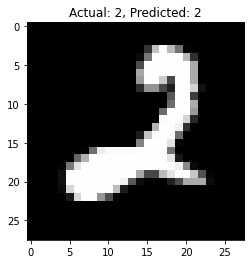

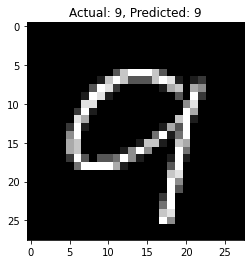

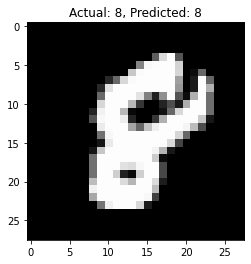

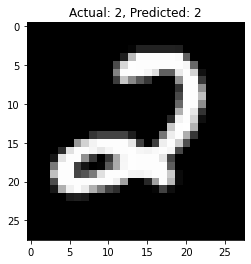

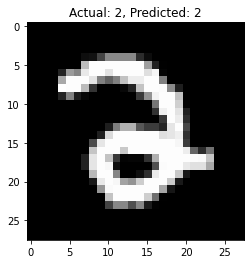

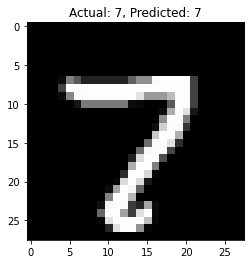

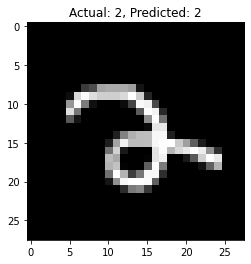

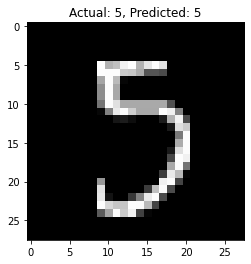

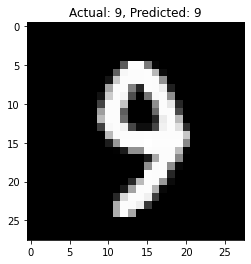

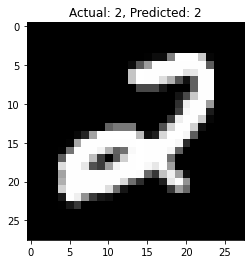

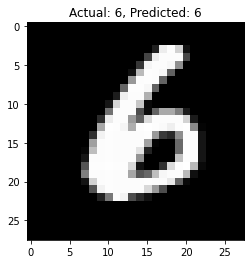

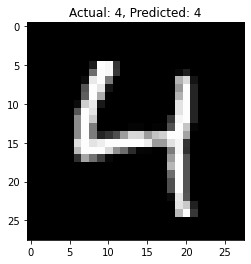

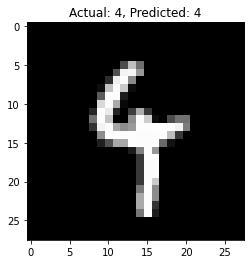

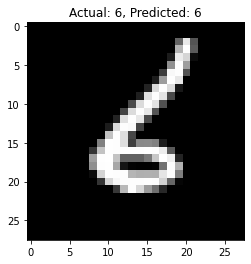

In [23]:
def visualize_results(model, dataloader, device):
    model.eval()

    # Get the total number of samples in the dataset
    total_samples = len(dataloader.dataset)

    # Randomly select 15 indices
    random_indices = random.sample(range(total_samples), 15)

    with torch.no_grad():
        for idx in random_indices:
            inputs, labels = dataloader.dataset[idx]
            inputs, labels = inputs.unsqueeze(0).to(device), torch.tensor([labels]).to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert tensors to NumPy arrays
            inputs = inputs.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()

            # Display the sample
            plt.imshow(np.squeeze(inputs), cmap='gray')
            plt.title(f"Actual: {labels.item()}, Predicted: {preds[0]}")
            plt.show()

# Call the function with the model and the test dataloader
visualize_results(net, testing_loader, device)

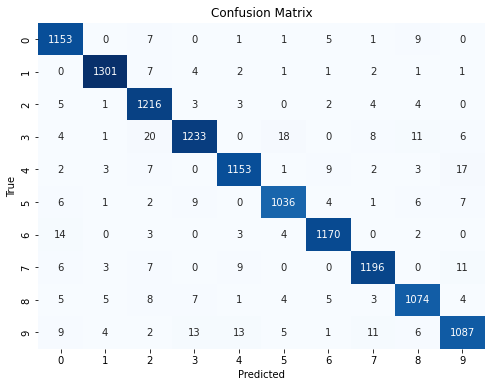

In [24]:
# Initialize variables for tracking predictions and labels
all_preds = []
all_labels = []

# Iterate over the testing data
for inputs, labels in testing_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    
    # Append predictions and labels for confusion matrix
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(all_labels, all_preds)
print(report)


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1177
           1       0.99      0.99      0.99      1320
           2       0.95      0.98      0.97      1238
           3       0.97      0.95      0.96      1301
           4       0.97      0.96      0.97      1197
           5       0.97      0.97      0.97      1072
           6       0.98      0.98      0.98      1196
           7       0.97      0.97      0.97      1232
           8       0.96      0.96      0.96      1116
           9       0.96      0.94      0.95      1151

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



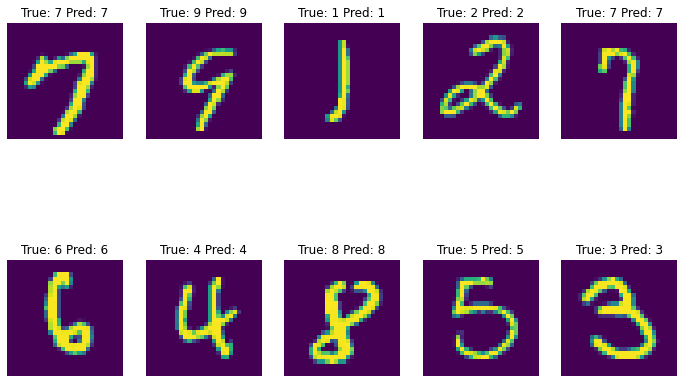

In [26]:
import numpy as np

# Get a few sample images and predictions
sample_images, sample_labels = next(iter(testing_loader))
sample_preds = net(sample_images.to(device)).cpu().detach().numpy()
sample_preds = np.argmax(sample_preds, axis=1)

# Plot sample images with predictions
plt.figure(figsize=(12, 8))
for i in range(10):  # Display 10 sample images
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i].permute(1, 2, 0).numpy())  # Convert to HxWxC
    plt.title(f'True: {sample_labels[i]} Pred: {sample_preds[i]}')
    plt.axis('off')
plt.show()
